最尤推定 ξ: 0.05050505050505005 σ: 2.8378631781360033 RV: 25.913353708658157
最尤推定 ξ: 0.06345506345506302 σ: 2.9623711642790713 RV: 27.64160785792307
65.3 %の確率で極値増加
最尤推定 ξ: 0.32245532245532205 σ: 2.4682286687495214 RV: 51.204533651629674
最尤推定 ξ: 0.2706552706552703 σ: 1.6123495749763495 RV: 30.268622389887
39.6 %の確率で極値増加
最尤推定 ξ: 0.1359751359751355 σ: 2.627728065517945 RV: 30.35625236429575
最尤推定 ξ: 0.11266511266511225 σ: 3.678379771828634 RV: 37.48165727187605
72.2 %の確率で極値増加
最尤推定 ξ: 0.14633514633514577 σ: 2.381471436053328 RV: 28.850529898208112
最尤推定 ξ: 0.08676508676508632 σ: 2.623030972952337 RV: 26.738148619183306
46.2 %の確率で極値増加
最尤推定 ξ: 0.0349650349650345 σ: 2.446247464353697 RV: 25.62291869527312
最尤推定 ξ: -0.011655011655012093 σ: 1.7288695996694154 RV: 19.06401335861149
11.7 %の確率で極値増加
最尤推定 ξ: -0.23957523957524002 σ: 2.3101297000831598 RV: 16.69712787760941
最尤推定 ξ: -0.09971509971510018 σ: 1.6210268552735165 RV: 16.43132545374624
47.0 %の確率で極値増加


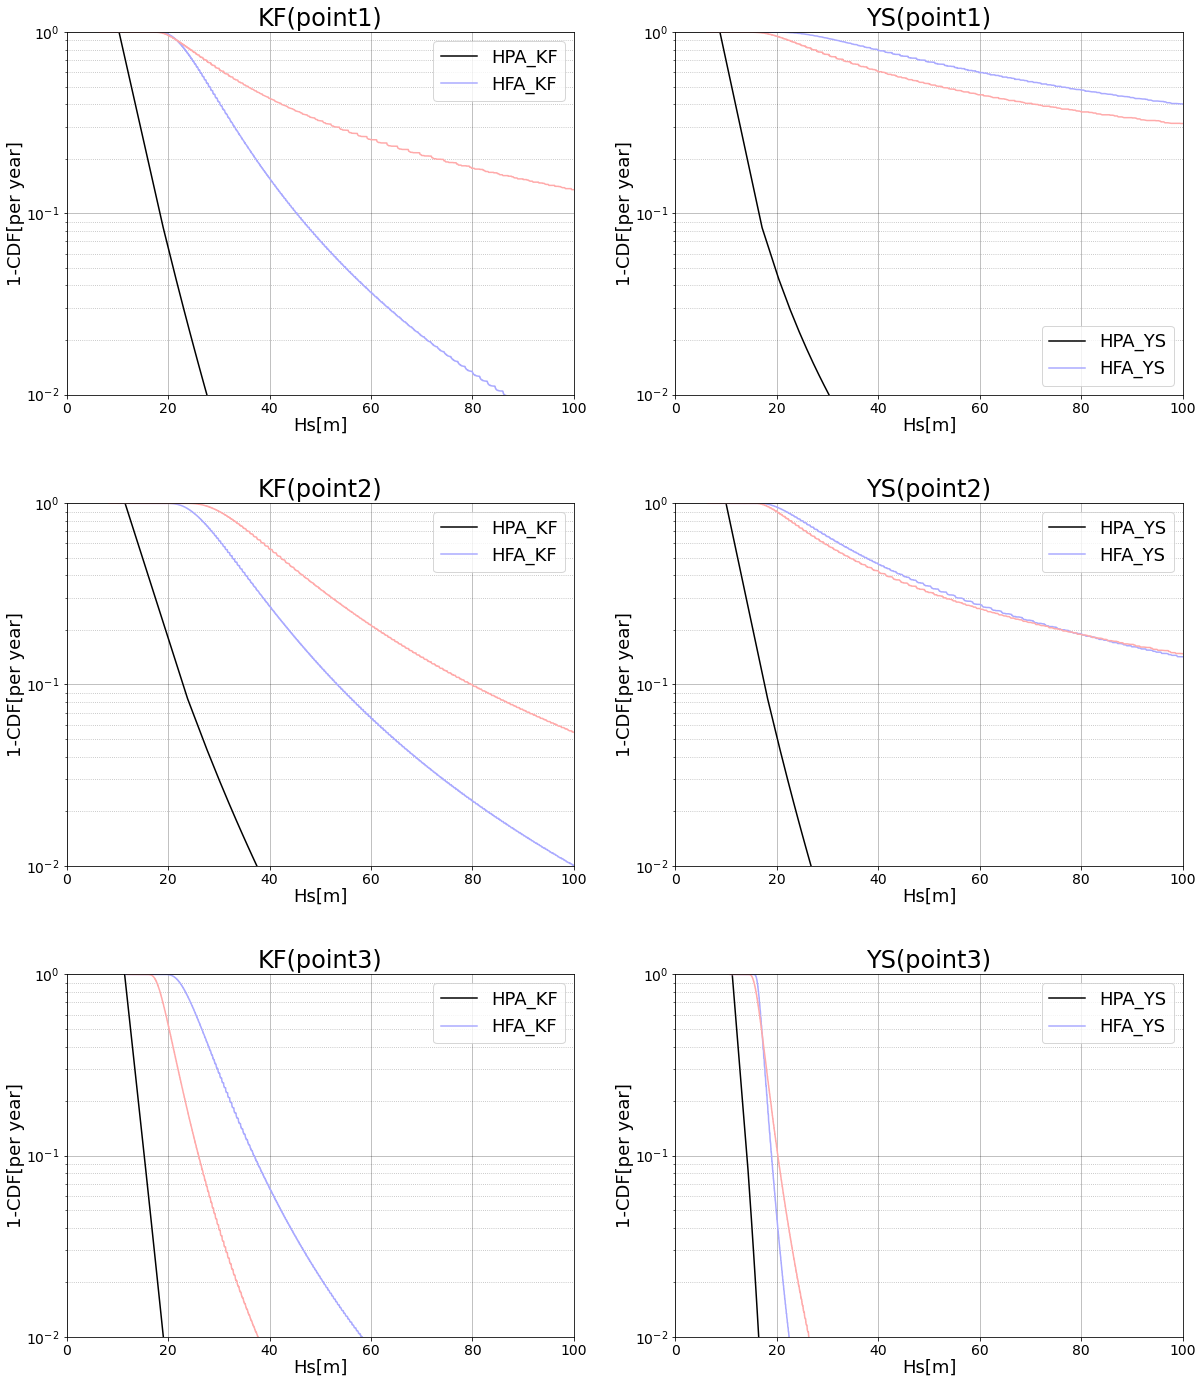

In [1]:
"""
LWMの出力結果を用いて, 極値増大確率を算出する.

"""

import func
from csv import reader
import matplotlib.pyplot as plt
import numpy as np

MODEL = ['KF', 'YS']
INDEX = [79*70 + 13, 79*49 + 34, 79*25 + 70]

def calc_p(past_rv, past_pro, f_rv, f_pro):
    """
    将来分布の中で, hsより大きい値を取る確率を合計する
    """
    P = 0
    for i in range(len(past_rv)):
        p = 0
        for j in range(len(f_rv)):
            if f_rv[j] > past_rv[i]:
                p += f_pro[j]
        P += past_pro[i] * p
    return P * 100

def cdf(rv, pro):
    Hs = []
    SUM = []
    sum = 1
    s = [(rv[i], pro[i]) for i in range(len(rv))]
    s.sort()
    for i in range(len(rv)):
        sum -= s[i][1]
        SUM.append(sum)
        Hs.append(s[i][0])
    return Hs, SUM

def rv(N, u, xi, sgm):
    """
    N年再現期待値の算出 
    """
    return u + sgm * ((N * 24 * 365 * 100 / 219143) ** xi - 1) / xi


DATA_CNT = 100

# 描画用の画像を用意
fig = plt.figure(figsize=(20, 24))
for index in range(len(INDEX)):
    idx = INDEX[index]
    for i in range(2):
        is_ok = True  # データ数がDATA_CNT以上あるかどうかのFlag(なければその地点は使用しない)
        for j in range(2):
            model = MODEL[i]
            # CSV名を指定するためにmodel名を変更
            if j == 0:  # 過去
                model = 'HPA_' + model
            else:  # 未来
                model = 'HFA_' + model + '_c0'
            with open('../pot_csv(100)(thr=6)/' + model + '_POT_DATA.csv', 'r') as csv_file:
                csv_reader = reader(csv_file)
                POT_ALL = list(csv_reader)
            POT = POT_ALL[idx] # 指定した場所のPOTを抽出
            # POTは文字列のリストになっているので, float型に変換する
            s = []
            for k in range(len(POT)):
                s.append(float(POT[k]))
            s = sorted(s, reverse=True)
            if len(POT) < 10:
                is_ok = False
                print("データ数：", len(POT), "データ数が不足しているため, この地点は使用できません")
            else:
                POT = s[:DATA_CNT]
                u = POT[-1]
                if j == 0:  # 過去
                    past_rv, past_pro, xi, sgm = func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=DATA_CNT, con=1.0)
                else:  # 将来
                    f_rv, f_pro, xi, sgm = func.lwm_gpd(data=POT, error=[0.005], thr=u, n=219143, n0=DATA_CNT, con=1.0)
        
        if is_ok:
            P = calc_p(past_rv, past_pro, f_rv, f_pro)
            cdf_p_hs, cdf_p_sum = cdf(past_rv, past_pro)
            cdf_f_hs, cdf_f_sum = cdf(f_rv, f_pro)
            print('{:.1f}'.format(P), '%の確率で極値増加')
            ax = fig.add_subplot(3, 2, 2 * index + i+1)
            # MLのplot
            x = np.linspace(1, 100, 10)
            ax.plot([rv(N=x_, u=u, xi=xi, sgm=sgm) for x_ in x], [1/x_ for x_ in x], color='black')
            ax.plot()
            ax.plot(cdf_p_hs, cdf_p_sum, c='#aaaaFF')
            ax.plot(cdf_f_hs, cdf_f_sum, c='#FFaaaa')
            ax.legend(['HPA_' + model[4:6], model[:-3]], fontsize=18)
            ax.set_xlim((0, 100))
            ax.set_ylim((0.01, 1))
            ax.set_xlabel("Hs[m]", fontsize=18, labelpad=1)
            ax.set_ylabel("1-CDF[per year]", fontsize=18, labelpad=1)
            ax.tick_params(axis='x', labelsize=14)
            ax.tick_params(axis='y', labelsize=14)
            ax.set_title(MODEL[i] + '(point' + str(index+1) + ')', fontsize=24)
            ax.set_yscale('log')
            ax.grid(which='major',color='black',linestyle='-', alpha=0.3)
            ax.grid(which='minor',color='black',linestyle='dotted', alpha=0.3)

plt.subplots_adjust(hspace=0.3)
# plt.savefig("../img/cdf.png")
plt.show()